In [1]:
import pickle
import pandas as pd
# 从本地文件加载变量
with open('/Users/tian/Downloads/data.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
import numpy as np

class SimpleAdaBoost:
    def __init__(self, base_estimator, n_estimators=10):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.classifiers = []
        self.alphas = []

    def fit(self, X, y):
        sample_weights = np.ones(X.shape[0]) / X.shape[0]
        for _ in range(self.n_estimators):
            clf = clone(self.base_estimator)
            clf.fit(X, y, sample_weight=sample_weights)
            pred = clf.predict(X)
            # 计算错误向量，其中错误为1，正确为0
            errors = pred != y
            # 用错误向量和样本权重计算加权错误率
            error_rate = np.dot(sample_weights, errors) / np.sum(sample_weights)

            # 避免除零错误，对极低的错误率做调整
            error_rate = max(error_rate, 1e-10)
            alpha = 0.5 * np.log((1 - error_rate) / error_rate)
            alpha = min(alpha, 0.6)  # max_alpha 是一个超参数，可以根据实际情况调整
            # 更新样本权重
            sample_weights *= np.exp(-alpha * y * (2 * errors - 1))
            sample_weights = np.maximum(sample_weights, 0.01/len(y))
            sample_weights /= np.sum(sample_weights)
            
            self.classifiers.append(clf)
            self.alphas.append(alpha)

    def predict(self, X):
        clf_preds = np.array([alpha * clf.predict(X) for clf, alpha in zip(self.classifiers, self.alphas)])
        return np.sign(np.sum(clf_preds, axis=0))

In [3]:
from tqdm import tqdm  # 导入tqdm
import numpy as np
from sklearn.base import clone  # 确保clone也被导入

class ManualOneVsOneClassifier:
    def __init__(self, base_estimator, n_estimators=10):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.pairwise_classifiers = []

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        # 为两两分类器组合总数初始化进度条
        progress_bar = tqdm(total=len(self.classes_) * (len(self.classes_) - 1) // 2, desc='Training Progress')
        for i, class1 in enumerate(self.classes_):
            for class2 in self.classes_[i+1:]:
                idx = (y == class1) | (y == class2)
                indices = np.where(idx)[0]
                X_pair = X[indices]
                y_pair = y[indices]
                y_binary = np.where(y_pair == class1, 1, -1)
                model = SimpleAdaBoost(clone(self.base_estimator), self.n_estimators)
                model.fit(X_pair, y_binary)
                self.pairwise_classifiers.append((class1, class2, model))
                progress_bar.update(1)  # 更新进度条
        progress_bar.close()  # 完成后关闭进度条

    def predict(self, X):
        votes = np.ones((X.shape[0], len(self.classes_))) * (1 / len(self.classes_))
        for class1, class2, model in self.pairwise_classifiers:
            preds = model.predict(X)
            index_class1 = np.where(self.classes_ == class1)[0][0]
            index_class2 = np.where(self.classes_ == class2)[0][0]
            for i, pred in enumerate(preds):
                if pred == 1:
                    votes[i, index_class1] += 1
                else:
                    votes[i, index_class2] += 1
        return self.classes_[np.argmax(votes, axis=1)]


In [4]:
base_classifier = DecisionTreeClassifier(max_depth=3)
ovo_classifier = ManualOneVsOneClassifier(base_classifier, n_estimators=10)
ovo_classifier.fit(X_train, np.array(y_train))
predictions = ovo_classifier.predict(X_test)

Training Progress: 100%|██████████| 10/10 [02:26<00:00, 14.65s/it]


Accuracy: 0.6047272727272728
Precision: 0.4384876443400113
Recall: 0.24986848638928424
F1 Score: 0.2451916505272495
Confusion Matrix:
[[   21     6     3    86   853]
 [   17    10    27   118   839]
 [   19     9   187   296  1670]
 [   21     8    60   938  3924]
 [   14     5    16   705 12148]]


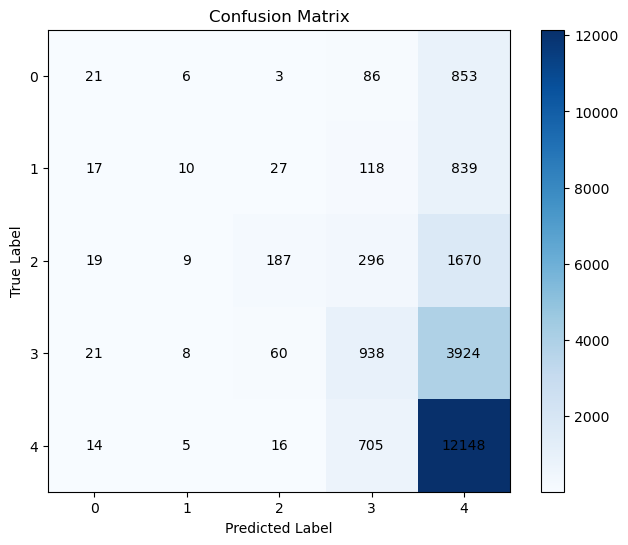

Mean Absolute Error (MAE): 0.6833181818181818
Root Mean Squared Error (RMSE): 1.257902294225661


In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# 计算准确率
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# 计算精确度
precision = precision_score(y_test, predictions, average='macro') # 'macro' 可以改为其他选项如 'micro', 'weighted', 'samples'
print("Precision:", precision)

# 计算召回率
recall = recall_score(y_test, predictions, average='macro') # 'macro' 可以改为其他选项如 'micro', 'weighted', 'samples'
print("Recall:", recall)

# 计算F1分数
f1 = f1_score(y_test, predictions, average='macro') # 'macro' 可以改为其他选项如 'micro', 'weighted', 'samples'
print("F1 Score:", f1)

# 输出混淆矩阵
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

import matplotlib.pyplot as plt

# 绘制热力图
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

# 显示数值
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

# 设置坐标轴标签
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 设置坐标轴刻度标签
tick_marks = range(len(conf_matrix))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

plt.show()


from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 计算MAE
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

# 计算RMSE
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)


In [11]:
base_classifier = DecisionTreeClassifier(max_depth=5)
ovo_classifier = ManualOneVsOneClassifier(base_classifier, n_estimators=15)
ovo_classifier.fit(X_train, np.array(y_train))
predictions = ovo_classifier.predict(X_test)

Training Progress: 100%|██████████| 10/10 [09:52<00:00, 59.23s/it]


Accuracy: 0.23586363636363636
Precision: 0.2397242479465232
Recall: 0.27282515236520793
F1 Score: 0.1608558061689179
Confusion Matrix:
[[ 766    0  128   33   42]
 [ 729    0  152   66   64]
 [1401    2  474  137  167]
 [2821    2  931  401  796]
 [6209    2 2100 1029 3548]]


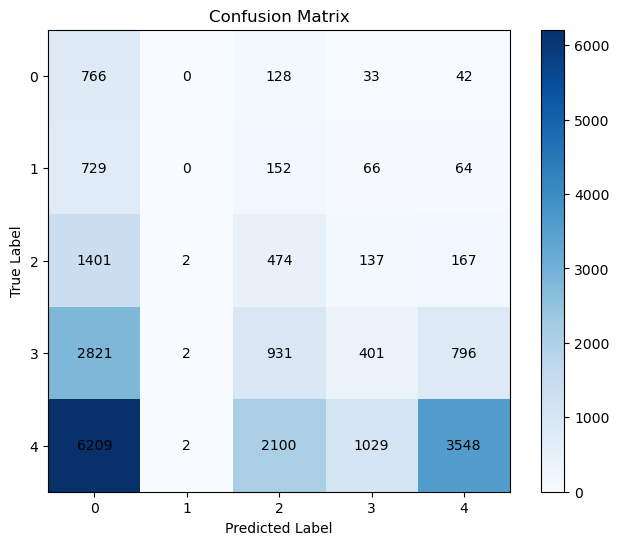

Mean Absolute Error (MAE): 2.0576363636363637
Root Mean Squared Error (RMSE): 2.5719465567754494


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# 计算准确率
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# 计算精确度
precision = precision_score(y_test, predictions, average='macro') # 'macro' 可以改为其他选项如 'micro', 'weighted', 'samples'
print("Precision:", precision)

# 计算召回率
recall = recall_score(y_test, predictions, average='macro') # 'macro' 可以改为其他选项如 'micro', 'weighted', 'samples'
print("Recall:", recall)

# 计算F1分数
f1 = f1_score(y_test, predictions, average='macro') # 'macro' 可以改为其他选项如 'micro', 'weighted', 'samples'
print("F1 Score:", f1)

# 输出混淆矩阵
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

import matplotlib.pyplot as plt

# 绘制热力图
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

# 显示数值
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

# 设置坐标轴标签
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 设置坐标轴刻度标签
tick_marks = range(len(conf_matrix))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

plt.show()


from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 计算MAE
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

# 计算RMSE
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
